# Reconnaissance d'Émotion Audio avec Deep Learning

Ce notebook détaille étape par étape la création d'une Intelligence Artificielle capable de détecter l'émotion (Colère, Joie, Tristesse, etc.) dans la voix humaine.

Nous utiliserons le dataset **CREMA-D** et une approche robuste basée sur :
1.  **MFCC (Mel-Frequency Cepstral Coefficients)** pour le traitement du signal.
2.  **CNN 1D (Réseau de Neurones Convolutif)** pour la classification.

---

## 1. Configuration et Imports
Importation des librairies nécessaires pour le traitement audio (`librosa`), la manipulation de données (`pandas`, `numpy`) et le Deep Learning (`tensorflow`).

In [19]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CONFIGURATION
---

In [20]:
# Chemin vers votre dossier contenant les fichiers .wav
DATA_PATH = "./AudioWAV"

# Configuration Audio
SAMPLE_RATE = 22050  # Fréquence d'échantillonnage (Hz)
DURATION = 2.5       # Durée fixe en secondes pour chaque extrait
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)

## 2. Chargement des Données
Les fichiers du dataset CREMA-D suivent une convention de nommage précise : `ActorID_SentenceID_Emotion_Level.wav`.
Nous allons parcourir le dossier pour extraire l'émotion de chaque fichier directement depuis son nom."

In [21]:
def load_data(data_path):
    data = []

    # Mapping des codes vers des noms lisibles
    emotion_map = {
        'ANG': 'Colère',
        'DIS': 'Dégoût',
        'FEA': 'Peur',
        'HAP': 'Joie',
        'NEU': 'Neutre',
        'SAD': 'Tristesse'
    }

    if not os.path.exists(data_path):
        print(f"ERREUR: Le dossier {data_path} n'existe pas.")
        return pd.DataFrame()

    print("Exploration des fichiers audio...")

    for filename in os.listdir(data_path):
        if filename.endswith('.wav'):
            # Structure: 1001_DFA_ANG_XX.wav
            parts = filename.split('_')

            if len(parts) >= 3:
                emotion_code = parts[2]

                if emotion_code in emotion_map:
                    data.append({
                        'path': os.path.join(data_path, filename),
                        'label': emotion_code,
                        'actor': parts[0]
                    })

    return pd.DataFrame(data)

In [22]:
# Exécution du chargement
df = load_data(DATA_PATH)
print(f"Fichiers trouvés : {len(df)}")

Exploration des fichiers audio...
Fichiers trouvés : 7442


C:\Users\arthu\AppData\Local\Temp\ipykernel_34316\168198241.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


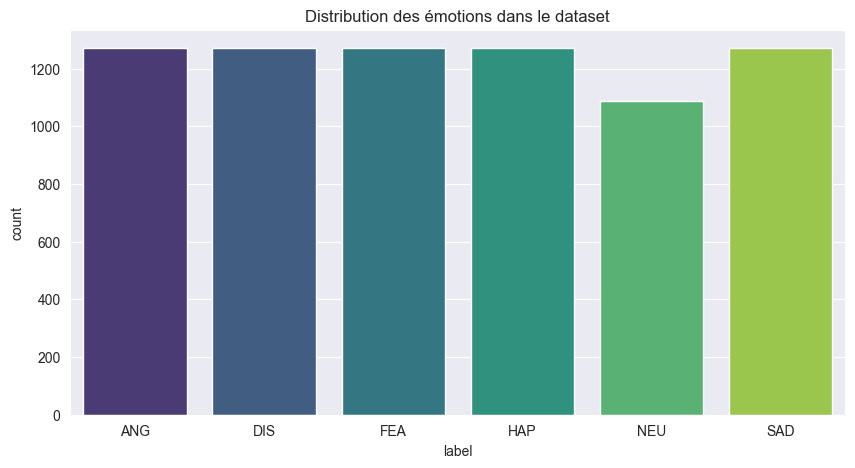

In [23]:
# Affichage de la distribution si des données sont trouvées
if not df.empty:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.title('Distribution des émotions dans le dataset')
    plt.show()

## 3. Extraction des Caractéristiques (Feature Extraction)
C'est l'étape critique. Un ordinateur ne "comprend" pas le son brut. Nous devons le transformer en matrice numérique.

Nous utilisons les **MFCC (Mel-Frequency Cepstral Coefficients)**. Imaginez cela comme une "empreinte digitale" du son qui capture le timbre de la voix sans se soucier de ce qui est dit.

**Traitements effectués :**
1.  **Chargement** : Lecture du fichier .wav avec `librosa`.
2.  **Padding/Truncating** : Tous les fichiers n'ont pas la même durée. Pour que le réseau de neurones fonctionne, nous devons forcer une taille unique (ici 2.5 secondes). On coupe si c'est trop long, on ajoute du silence si c'est trop court.
3.  **MFCC** : Calcul des coefficients.

In [24]:
def extract_features(file_path):
    try:
        # 1. Chargement de l'audio
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # 2. Padding / Truncating (Uniformisation de la longueur)
        if len(audio) > SAMPLES_PER_TRACK:
            # Si trop long, on coupe au milieu
            center = len(audio) // 2
            start = center - (SAMPLES_PER_TRACK // 2)
            audio = audio[start : start + SAMPLES_PER_TRACK]
        else:
            # Si trop court, on ajoute des zéros à la fin
            padding = SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # 3. Extraction MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

        # Transposition pour avoir (Temps, Features) pour le CNN
        return mfcc.T

    except Exception as e:
        print(f"Erreur fichier {file_path}: {e}")
        return None

In [25]:
def prepare_dataset(df):
    print("Début de l'extraction des features (Patientez, cela peut être long)...")
    X = []
    y = []

    # Utilisation de tqdm pour la barre de progression si installé
    try:
        from tqdm.notebook import tqdm
        iterable = tqdm(df.iterrows(), total=len(df))
    except ImportError:
        iterable = df.iterrows()

    for index, row in iterable:
        feature = extract_features(row['path'])
        if feature is not None:
            X.append(feature)
            y.append(row['label'])

    return np.array(X), np.array(y)

In [26]:
# Lancement du traitement (uniquement si DF n'est pas vide)
if not df.empty:
    X, y_text = prepare_dataset(df)
    print(f"Forme des données d'entrée X : {X.shape}")

Début de l'extraction des features (Patientez, cela peut être long)...
Forme des données d'entrée X : (7442, 108, 40)


## 4. Préparation à l'Entraînement
Avant de nourrir le modèle, nous devons :
1.  **Encoder les labels** : Transformer "Colère" en `0`, "Joie" en `1`, etc., puis en vecteur binaire (**One-Hot Encoding**).
2.  **Diviser les données** : Séparer les données en un jeu d'entraînement (**Train**) pour apprendre et un jeu de test (**Test**) pour valider la performance.

In [27]:
if not df.empty:
    # Encodage Texte -> Nombres
    lb = LabelEncoder()
    y_indices = lb.fit_transform(y_text)

    # Encodage Nombres -> One-Hot (vecteurs)
    y_onehot = to_categorical(y_indices)
    print("Classes détectées :", lb.classes_)

    # Split Train / Test (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
    )

    # Split Train / Validation (10% du Train pour la validation interne)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42
    )

    print(f"Données d'entraînement : {X_train.shape}")
    print(f"Données de validation : {X_val.shape}")
    print(f"Données de test : {X_test.shape}")

Classes détectées : ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']
Données d'entraînement : (5357, 108, 40)
Données de validation : (596, 108, 40)
Données de test : (1489, 108, 40)


## 5. Architecture Multi-Modèles
Pour déterminer la meilleure approche pour classifier les émotions dans la voix, nous allons comparer trois architectures de Deep Learning très différentes :

1.  **CNN 1D (Convolutional Neural Network)** :
    * **Concept** : Traite le son comme une image. Il cherche des motifs locaux (fréquences, pics d'énergie) indépendamment de leur position temporelle.
    * **Force** : Rapide et efficace pour extraire des caractéristiques "brutes".

2.  **LSTM (Long Short-Term Memory)** :
    * **Concept** : C'est un réseau récurrent (RNN) spécialisé dans les séquences. Il lit le fichier audio du début à la fin et possède une "mémoire" pour retenir le contexte (ex: une intonation au début de la phrase influence la fin).
    * **Force** : Comprend la dynamique temporelle et l'évolution de l'émotion.

3.  **CRNN (Hybride Convolutional + Recurrent)** :
    * **Concept** : Le meilleur des deux mondes. On utilise d'abord des couches **CNN** pour "nettoyer" le signal et extraire les caractéristiques importantes, puis on envoie ces caractéristiques à un **LSTM** pour analyser leur séquence.
    * **Force** : Souvent l'état de l'art en traitement audio.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Input, LSTM, Bidirectional

def get_model(model_name, input_shape, num_classes):
    model = Sequential()

    # MODÈLE 1 : CNN 1D
    if model_name == 'CNN':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(64, kernel_size=5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, kernel_size=5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.3))

    # MODÈLE 2 : LSTM
    elif model_name == 'LSTM':
        model.add(Input(shape=input_shape))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Dropout(0.3))

        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.3))

        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))

    # MODÈLE 3 : CRNN
    elif model_name == 'CRNN':
        model.add(Input(shape=input_shape))

        # 1. Extraction de features avec CNN
        model.add(Conv1D(64, 5, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, 5, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))

        # 2. Analyse séquentielle avec LSTM
        model.add(LSTM(128))
        model.add(Dropout(0.3))

        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))

    # Couche de sortie finale (Classification)
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [29]:
if not df.empty:
    input_shape = (X.shape[1], X.shape[2])
    num_classes = len(lb.classes_)

    model1 = get_model('CNN', input_shape, num_classes)
    model1.summary()

    model2 = get_model('LSTM', input_shape, num_classes)
    model2.summary()

    model3 = get_model('CRNN', input_shape, num_classes)
    model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 108, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 108, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 54, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 498,502 (1.90 MB)

 Trainable params: 497,862 (1.90 MB)

 Non-trainable params: 640 (2.50 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 108, 256)       │       173,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 108, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,054 (1.32 MB)

 Trainable params: 346,054 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 108, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 54, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,182 (758.52 KB)

 Trainable params: 194,182 (758.52 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Entraînement Comparatif
Nous allons maintenant entraîner les 3 modèles successivement sur les mêmes données.

Pour assurer une comparaison équitable :
1.  Chaque modèle utilise les mêmes hyperparamètres (batch size, optimiseur).
2.  Nous utilisons l'**EarlyStopping** : l'entraînement s'arrête si le modèle cesse de progresser sur le jeu de validation (évite le surapprentissage).
3.  Nous stockons l'historique de chaque entraînement dans un dictionnaire `history_dict` pour pouvoir tracer les courbes ensuite.

In [30]:
# Liste des architectures à tester
model_names = ['CNN', 'LSTM', 'CRNN']

# Dictionnaires pour stocker les résultats
history_dict = {}
trained_models = {}

if not df.empty:
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = len(lb.classes_)

    for name in model_names:
        print(f"\n{'='*40}")
        print(f"Démarrage de l'entraînement : {name}")
        print(f"{'='*40}")

        # Initialisation
        model = get_model(name, input_shape, num_classes)

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

        # Entraînement
        history = model.fit(X_train, y_train,
                            epochs=40,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stop, reduce_lr],
                            verbose=1)

        # Stockage
        history_dict[name] = history
        trained_models[name] = model

        print(f"Entraînement terminé pour {name}")


🚀 Démarrage de l'entraînement : CNN
Epoch 1/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4006 - loss: 1.5310 - val_accuracy: 0.3909 - val_loss: 1.7635 - learning_rate: 0.0010
Epoch 2/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4936 - loss: 1.3091 - val_accuracy: 0.3104 - val_loss: 1.8434 - learning_rate: 0.0010
Epoch 3/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5326 - loss: 1.2034 - val_accuracy: 0.4681 - val_loss: 1.3901 - learning_rate: 0.0010
Epoch 4/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5813 - loss: 1.0922 - val_accuracy: 0.4346 - val_loss: 1.5240 - learning_rate: 0.0010
Epoch 5/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6061 - loss: 1.0238 - val_accuracy: 0.5017 - val_loss: 1.2537 - learning_rate: 0.0010
Epoch 6/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6446 - loss: 0.9430 - val_accuracy: 0.4765 - val_loss: 1.4167 - learning_rate: 0.0010
Epoch 7/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 14

In [44]:
# Création d'un dossier pour organiser les sauvegardes
if not os.path.exists('sauvegardes_v1'):
    os.makedirs('sauvegardes_v1')

print(f"{'='*40}")
print("SAUVEGARDE DES MODÈLES V1 (Base)")
print(f"{'='*40}")

if 'trained_models' in locals() and trained_models:
    for name, model in trained_models.items():
        # On utilise le format .keras (standard actuel de TensorFlow)
        filename = f"sauvegardes_v1/model_v1_{name}.keras"
        model.save(filename)
        print(f"Modèle {name} sauvegardé : {filename}")
else:
    print("Attention : Aucun modèle V1 trouvé en mémoire.")

💾 SAUVEGARDE DES MODÈLES V1 (Base)
✅ Modèle CNN sauvegardé : sauvegardes_v1/model_v1_CNN.keras
✅ Modèle LSTM sauvegardé : sauvegardes_v1/model_v1_LSTM.keras
✅ Modèle CRNN sauvegardé : sauvegardes_v1/model_v1_CRNN.keras


## 7. Comparaison des Performances
Visualisons graphiquement les résultats. Nous regardons deux métriques :
* **Accuracy (Précision)** : Plus elle est haute, mieux c'est.
* **Loss (Perte)** : Plus elle est basse, mieux c'est.

Nous allons également évaluer chaque modèle sur le **Jeu de Test** (données que le modèle n'a jamais vues, ni à l'entraînement, ni à la validation) pour déterminer le grand gagnant.

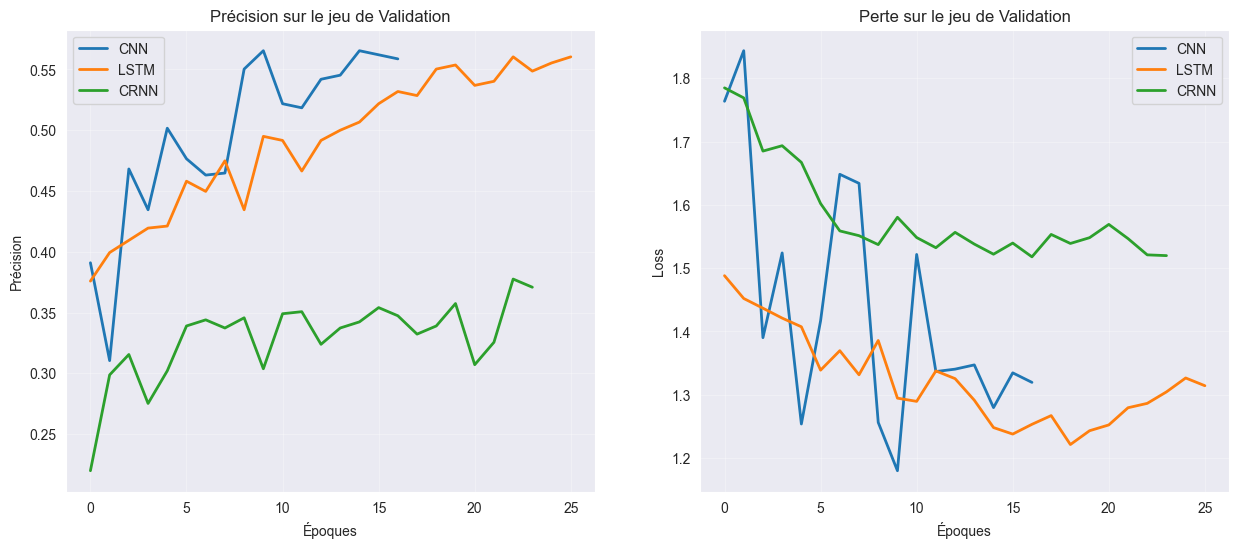


🏆 RÉSULTATS FINAUX SUR LE JEU DE TEST
Modèle CNN   -> Précision : 58.90% | Perte : 1.1126
Modèle LSTM  -> Précision : 59.91% | Perte : 1.1125
Modèle CRNN  -> Précision : 35.66% | Perte : 1.5230

🌟 LE GAGNANT EST : LSTM avec 59.91% de précision !
Le modèle LSTM a été sauvegardé sous 'best_emotion_model.keras'


In [31]:
if not df.empty:
    plt.figure(figsize=(15, 6))

    # Graphique 1 : Précision (Accuracy)
    plt.subplot(1, 2, 1)
    for name, history in history_dict.items():
        plt.plot(history.history['val_accuracy'], label=f'{name}', linewidth=2)
    plt.title('Précision sur le jeu de Validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Graphique 2 : Perte (Loss)
    plt.subplot(1, 2, 2)
    for name, history in history_dict.items():
        plt.plot(history.history['val_loss'], label=f'{name}', linewidth=2)
    plt.title('Perte sur le jeu de Validation')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

    print(f"\n{'='*40}")
    print("RÉSULTATS FINAUX SUR LE JEU DE TEST")
    print(f"{'='*40}")

    best_acc = 0
    best_model_name = ""

    for name, model in trained_models.items():
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Modèle {name.ljust(5)} -> Précision : {acc*100:.2f}% | Perte : {loss:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_model_name = name

    print(f"\nLE MEILLEUR MODEL EST : {best_model_name} avec {best_acc*100:.2f}% de précision !")

    # On sauvegarde uniquement le meilleur modèle
    trained_models[best_model_name].save("best_emotion_model.keras")
    print(f"Le modèle {best_model_name} a été sauvegardé sous 'best_emotion_model.keras'")

## 8. Amélioration des Données : Data Augmentation & Mel-Spectrogrammes

Pour dépasser le plafond de verre des 60% et corriger le CRNN, nous changeons notre approche de traitement de données :

1.  **Data Augmentation** : Chaque fichier audio sera utilisé 3 fois :
    * Version Originale.
    * Version **Bruitée** (simule un environnement réel).
    * Version **Décalée** (Time Shift) pour que le modèle ne retienne pas juste la position exacte du son.
    * *Résultat : Le dataset passe de ~7 000 à ~21 000 exemples.*

2.  **Mel-Spectrogrammes** : Au lieu des MFCC (40 caractéristiques), nous utilisons des Mel-Spectrogrammes (128 caractéristiques). C'est une représentation visuelle du son plus riche en détails fréquentiels, essentielle pour distinguer des émotions subtiles comme "Triste" vs "Neutre".

In [33]:
# Fonction pour ajouter du bruit et décaler le son
def augment_audio(audio, sr):
    augmentations = []

    # 1. Original
    augmentations.append(audio)

    # 2. Ajout de Bruit (Noise Injection)
    # On ajoute un bruit blanc de faible amplitude
    noise_factor = 0.005
    noise = np.random.randn(len(audio))
    augmented_noise = audio + noise_factor * noise
    augmentations.append(augmented_noise)

    # 3. Décalage Temporel (Time Shift)
    # On décale le son aléatoirement vers la gauche ou la droite
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    augmented_shift = np.roll(audio, shift_range)
    augmentations.append(augmented_shift)

    return augmentations

# Fonction pour convertir en Mel-Spectrogramme (plus riche que MFCC)
def get_mel_spectrogram(audio, sr):
    # n_mels=128 donne une "image" plus haute (plus de détails fréquenciels)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db.T  # Transposition pour (Temps, Features)

In [34]:
def prepare_augmented_dataset(df):
    print("Génération du dataset augmenté (x3) avec Mel-Spectrogrammes...")
    X_aug = []
    y_aug = []

    # Barre de progression si disponible
    try:
        from tqdm.notebook import tqdm
        iterable = tqdm(df.iterrows(), total=len(df))
    except ImportError:
        iterable = df.iterrows()

    for index, row in iterable:
        try:
            # Chargement et Padding/Truncating (comme avant)
            audio, sr = librosa.load(row['path'], sr=SAMPLE_RATE)
            if len(audio) > SAMPLES_PER_TRACK:
                audio = audio[:SAMPLES_PER_TRACK]
            else:
                padding = SAMPLES_PER_TRACK - len(audio)
                audio = np.pad(audio, (0, padding), mode='constant')

            # Augmentation : 1 fichier -> 3 versions audio
            audios = augment_audio(audio, sr)

            for aud in audios:
                # Transformation en Mel-Spectrogramme
                feature = get_mel_spectrogram(aud, sr)

                X_aug.append(feature)
                y_aug.append(row['label']) # On duplique le label pour chaque version

        except Exception as e:
            print(f"Erreur sur {row['path']}: {e}")

    return np.array(X_aug), np.array(y_aug)

# Exécution
if not df.empty:
    X_new, y_text_new = prepare_augmented_dataset(df)
    print(f"Nouvelle taille du dataset : {X_new.shape}")

Génération du dataset augmenté (x3) avec Mel-Spectrogrammes...
Nouvelle taille du dataset : (22326, 108, 128)


In [35]:
if not df.empty:
    # Ré-encodage des labels
    lb = LabelEncoder()
    y_indices_new = lb.fit_transform(y_text_new)
    y_onehot_new = to_categorical(y_indices_new)

    # Nouveau Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_new, y_onehot_new, test_size=0.2, random_state=42, stratify=y_onehot_new
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42
    )

    print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

Train: (16074, 108, 128) | Val: (1786, 108, 128) | Test: (4466, 108, 128)


## 9. Architectures Améliorées et Optimiseur Ajusté

Nous mettons à jour la définition des modèles pour intégrer les correctifs nécessaires :

1.  **CRNN Corrigé** : Ajout de couches `BatchNormalization` après chaque convolution. Cela stabilise les valeurs qui sortent du CNN avant d'entrer dans le LSTM, résolvant le problème de la précision à 35%.
2.  **Input Shape** : Adapté à `(128 features)` au lieu de 40.
3.  **Optimiseur** : Utilisation d'un *Learning Rate* plus faible (`0.0005`) pour éviter que le modèle ne converge trop vite vers une mauvaise solution.

In [36]:
from tensorflow.keras.optimizers import Adam

def get_model_v2(model_name, input_shape, num_classes):
    model = Sequential()

    # Optimiseur plus lent et précis
    opt = Adam(learning_rate=0.0005)

    # CNN 1D Amélioré
    if model_name == 'CNN':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(64, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.3))

        model.add(Conv1D(128, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.3))

        model.add(Conv1D(256, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

    # LSTM Amélioré
    elif model_name == 'LSTM':
        model.add(Input(shape=input_shape))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))

    # CRNN Corrigé
    elif model_name == 'CRNN':
        model.add(Input(shape=input_shape))

        # Bloc CNN avec BatchNormalization STRICTE
        model.add(Conv1D(64, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.3))

        model.add(Conv1D(128, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.3))

        # LSTM simplifié
        model.add(LSTM(64))
        model.add(Dropout(0.4))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [37]:
model_names = ['CNN', 'LSTM', 'CRNN']
history_dict_v2 = {}
trained_models_v2 = {}

if not df.empty:
    input_shape = (X_train.shape[1], X_train.shape[2])

    for name in model_names:
        print(f"\nEntraînement V2 : {name}")

        model = get_model_v2(name, input_shape, len(lb.classes_))

        early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001)

        history = model.fit(X_train, y_train,
                            epochs=40,
                            batch_size=64, # Batch size augmenté car plus de données
                            validation_data=(X_val, y_val),
                            callbacks=[early_stop, reduce_lr],
                            verbose=1)

        history_dict_v2[name] = history
        trained_models_v2[name] = model


>>> Entraînement V2 : CNN
Epoch 1/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.3320 - loss: 1.8353 - val_accuracy: 0.3326 - val_loss: 1.5621 - learning_rate: 5.0000e-04
Epoch 2/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.3972 - loss: 1.5343 - val_accuracy: 0.2234 - val_loss: 3.8683 - learning_rate: 5.0000e-04
Epoch 3/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4430 - loss: 1.4113 - val_accuracy: 0.3421 - val_loss: 1.9832 - learning_rate: 5.0000e-04
Epoch 4/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.4813 - loss: 1.3115 - val_accuracy: 0.3488 - val_loss: 1.5882 - learning_rate: 5.0000e-04
Epoch 5/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.5144 - loss: 1.2484 - val_accuracy: 0.3544 - val_loss: 1.5045 - learning_rate: 5.0000e-04
Epoch 6/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5269 - loss: 1.2180 - val_accuracy: 0.2889 - val_loss: 2.3445 - learning_rate: 5.0000e-04
Epoch 7/40
252/252 ━━━━━━━

In [45]:
# Création d'un dossier spécifique pour la V2
if not os.path.exists('sauvegardes_v2'):
    os.makedirs('sauvegardes_v2')

print(f"{'='*40}")
print("SAUVEGARDE DES MODÈLES V2")
print(f"{'='*40}")

if 'trained_models_v2' in locals() and trained_models_v2:
    for name, model in trained_models_v2.items():
        filename = f"sauvegardes_v2/model_v2_{name}.keras"
        model.save(filename)
        print(f"Modèle {name} sauvegardé : {filename}")

    # On sauvegarde aussi le meilleur des 3 séparément pour un accès rapide
    if 'best_model_name' in locals():
        best_path = "best_model_final.keras"
        trained_models_v2[best_model_name].save(best_path)
        print(f"\nLe meilleur modèle ({best_model_name}) a aussi été copié sous : {best_path}")
else:
    print("Attention : Aucun modèle V2 trouvé en mémoire.")

💾 SAUVEGARDE DES MODÈLES V2 (Augmentés)
✅ Modèle CNN sauvegardé : sauvegardes_v2/model_v2_CNN.keras
✅ Modèle LSTM sauvegardé : sauvegardes_v2/model_v2_LSTM.keras
✅ Modèle CRNN sauvegardé : sauvegardes_v2/model_v2_CRNN.keras

🏆 Le champion (CRNN) a aussi été copié sous : best_model_final.keras


In [38]:
if not df.empty:
    print(f"\n{'='*40}")
    print("RÉSULTATS V2")
    print(f"{'='*40}")

    best_acc = 0
    best_model_name = ""

    for name, model in trained_models_v2.items():
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Modèle {name.ljust(5)} -> Précision : {acc*100:.2f}% | Perte : {loss:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_model_name = name

    print(f"\nLE NOUVEAU MEILLEUR MODELE EST : {best_model_name} avec {best_acc*100:.2f}%")


🏆 RÉSULTATS V2 (Data Augmentation + Mel-Spec)
Modèle CNN   -> Précision : 66.48% | Perte : 0.8858
Modèle LSTM  -> Précision : 48.21% | Perte : 1.2992
Modèle CRNN  -> Précision : 70.15% | Perte : 0.7935

🌟 LE NOUVEAU GAGNANT EST : CRNN avec 70.15%


## 10. Test en conditions réelles (Inférence)

Maintenant que nous avons identifié le meilleur modèle (sauvegardé dans `best_model_name`), nous allons le tester sur un fichier audio externe totalement inconnu du système : `TestAudio.wav`.

**Étapes critiques :**
1.  Charger le fichier audio.
2.  Le redimensionner pour qu'il fasse exactement 2.5 secondes (comme lors de l'entraînement).
3.  Le convertir en Mel-Spectrogramme.
4.  Lui faire traverser le modèle gagnant.


--- Test du fichier : TestAudio.wav ---
Analyse du fichier : TestAudio.wav...

🎤 RÉSULTAT : FEA
📊 Confiance : 45.41%



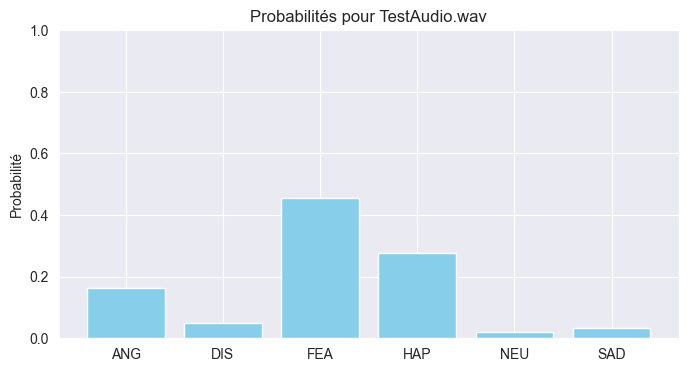


--- Test du fichier : TestAudioHappy.wav ---
Analyse du fichier : TestAudioHappy.wav...

🎤 RÉSULTAT : HAP
📊 Confiance : 60.88%



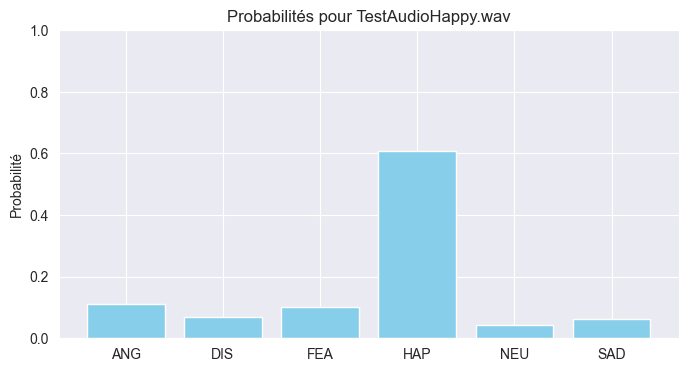


--- Test du fichier : TestAudioSad.wav ---
Analyse du fichier : TestAudioSad.wav...

🎤 RÉSULTAT : HAP
📊 Confiance : 50.82%



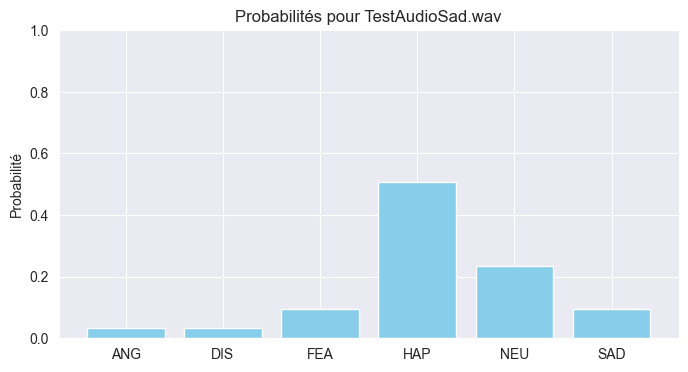

In [47]:
def predict_custom_audio(file_path, model, classes):
    print(f"Analyse du fichier : {file_path}...")

    try:
        # 1. Chargement
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # 2. Uniformisation de la durée (Padding / Truncating)
        if len(audio) > SAMPLES_PER_TRACK:
            audio = audio[:SAMPLES_PER_TRACK]
        else:
            padding = SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # 3. Extraction des Features (Mel-Spectrogramme)
        mel_spec = get_mel_spectrogram(audio, sr) # Shape: (Temps, 128)

        # 4. Adaptation pour le modèle (Ajout dimension Batch)
        input_data = np.expand_dims(mel_spec, axis=0)

        # 5. Prédiction
        predictions = model.predict(input_data, verbose=0)
        predicted_index = np.argmax(predictions)
        confidence = np.max(predictions)
        predicted_label = classes[predicted_index]

        # 6. Affichage des résultats
        print(f"\n{'='*30}")
        print(f"RÉSULTAT : {predicted_label.upper()}")
        print(f"Confiance : {confidence*100:.2f}%")
        print(f"{'='*30}\n")

        # Petit graphique des probabilités
        plt.figure(figsize=(8, 4))
        plt.bar(classes, predictions[0], color='skyblue')
        plt.title(f"Probabilités pour {file_path}")
        plt.ylabel("Probabilité")
        plt.ylim(0, 1)
        plt.show()

        return predicted_label

    except FileNotFoundError:
        print(f"ERREUR : Le fichier '{file_path}' est introuvable. Vérifiez le nom ou le chemin.")
    except Exception as e:
        print(f"Une erreur est survenue : {e}")

# --- EXÉCUTION DU TEST ---

# On récupère le meilleur modèle entraîné précédemment
if not df.empty and 'best_model_name' in locals():
    best_model = trained_models_v2[best_model_name]

    file_to_test = "TestAudioHappy.wav"
    print(f"\n--- Test du fichier : {file_to_test} ---")
    predict_custom_audio(file_to_test, best_model, lb.classes_)
else:
    print("Veuillez d'abord exécuter l'entraînement.")